# Projet SQUAD

## Exploiration des donnees

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
# file name
train_file='/Users/ciscom/Desktop/Cours/M2/ML/Projet_SQuAD/data/train-v2.0.json'
dev_file = '/Users/ciscom/Desktop/Cours/M2/ML/Projet_SQuAD/data/dev-v2.0.json'
T5_model = '/Users/ciscom/Desktop/Cours/M2/ML/Projet_SQuAD/models'

### Chargement du fichier json -> pandas

In [4]:
import json

In [ ]:
def load_data_from_json(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        squad_dict = json.load(f)

    data = []

    for article in squad_dict['data']:
        title = article['title']
        for paragraph in article['paragraphs']:
            context = paragraph['context']
            for qa in paragraph['qas']:
                question = qa['question']
                id_ = qa['id']
                is_impossible = qa.get('is_impossible', False) # Spécifique v2.0
                
                if not is_impossible:
                    # Question avec réponse
                    if 'answers' in qa and len(qa['answers']) > 0:
                        answer_text = qa['answers'][0]['text']
                        answer_start = qa['answers'][0]['answer_start']
                    else:
                        answer_text = ""
                        answer_start = -1
                else:
                    # Question impossible
                    answer_text = "unanswerable"  
                    answer_start = -1
                
                data.append({
                    'id': id_,
                    'title': title,
                    'context': context,
                    'question': question,
                    'is_impossible': is_impossible, 
                    'answer_text': answer_text,
                    'answer_start': answer_start
                })

    return pd.DataFrame(data)

 ### Répartition Possible vs Impossible

Nombre total de questions : 130319

--- Répartition des questions ---
is_impossible
False    86821
True     43498
Name: count, dtype: int64


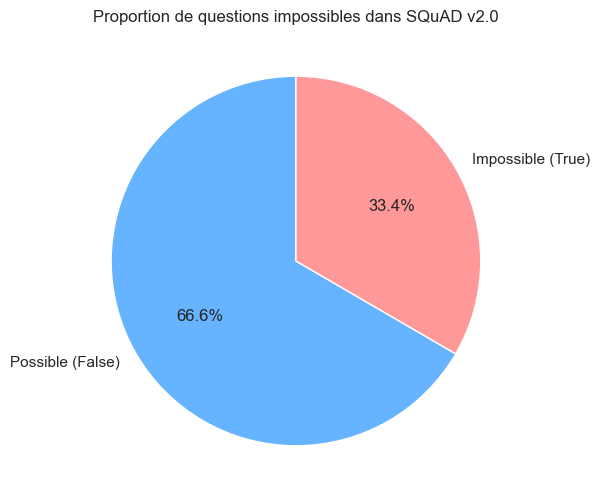

In [29]:
# 1. Chargement
sns.set_theme(style="whitegrid")
df_train = squad_v2_to_dataframe(train_file)

# 2. Vérification rapide
print(f"Nombre total de questions : {len(df_train)}")

# 3. Analyse : Combien de questions sont impossibles ?
impossible_counts = df_train['is_impossible'].value_counts()
print("\n--- Répartition des questions ---")
print(impossible_counts)

# Visualisation (Camembert)
plt.figure(figsize=(6, 6))
plt.pie(impossible_counts, labels=['Possible (False)', 'Impossible (True)'], 
        autopct='%1.1f%%', colors=['#66b3ff','#ff9999'], startangle=90)
plt.title('Proportion de questions impossibles dans SQuAD v2.0')
plt.show()

### Longueur des Contextes

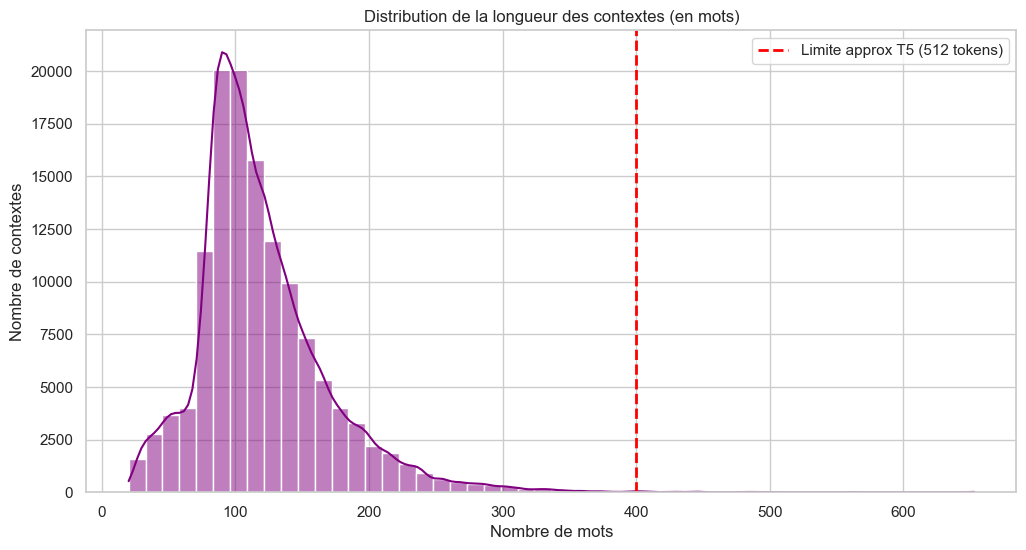

In [ ]:
# On compte le nombre de mots (approximation des tokens)
df_train['context_length'] = df_train['context'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 6))
sns.histplot(df_train['context_length'], bins=50, kde=True, color='purple')

# Note : 1 mot ≈ 1.3 tokens. Donc 512 tokens ≈ 390 mots.
plt.axvline(x=400, color='red', linestyle='--', linewidth=2, label='Limite approx T5 (512 tokens)')

plt.title("Distribution de la longueur des contextes (en mots)")
plt.xlabel("Nombre de mots")
plt.ylabel("Nombre de contextes")
plt.legend()
plt.show()

### Longueur des Contextes

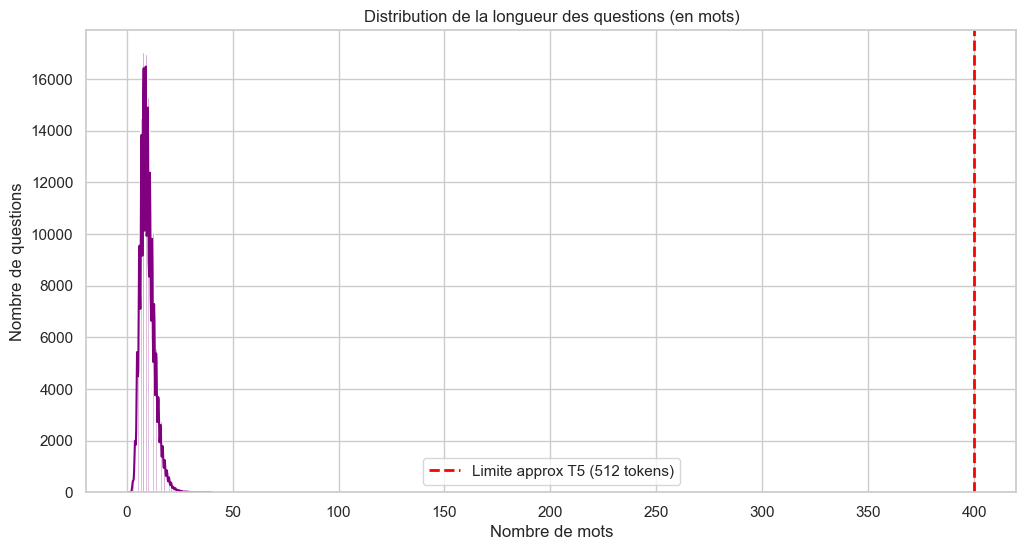

In [ ]:
df_train['question_length'] = df_train['question'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 6))
sns.histplot(df_train['question_length'], bins=50, kde=True, color='purple')

plt.axvline(x=400, color='red', linestyle='--', linewidth=2, label='Limite approx T5 (512 tokens)')

plt.title("Distribution de la longueur des questions (en mots)")
plt.xlabel("Nombre de mots")
plt.ylabel("Nombre de questions")
plt.legend()
plt.show()

## Pre-traitement des donnees

In [ ]:
from datasets import Dataset

# 1. Chargement via votre fonction
df_train = load_data_from_json(train_file)
df_dev = load_data_from_json(dev_file)


print(f"Train size: {len(df_train)}")
print(f"Eval size: {len(df_dev)}")

Train size: 130319
Eval size: 11873


### Tokenisation

In [ ]:
from transformers import AutoTokenizer

model_checkpoint = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

max_input_length = 512 # taille max 
max_target_length = 128

def preprocess_function(examples):
    # 1. Préparation des entrées : "question: ... context: ..."
    inputs = [f"question: {q} context: {c}" for q, c in zip(examples["question"], examples["context"])]
    

    targets = examples["answer_text"]
    
    # 3. Tokenization des Entrées
    model_inputs = tokenizer(
        inputs, 
        max_length=max_input_length, 
        truncation=True, 
        padding="max_length"
    )

    # 4. Tokenization des Cibles (Labels)
    labels = tokenizer(
        text_target=targets, 
        max_length=max_target_length, 
        truncation=True, 
        padding="max_length"
    )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

### Conversion explicite de Pandas vers Hugging Face

In [ ]:
from datasets import Dataset


hf_train_dataset = Dataset.from_pandas(df_train)
hf_eval_dataset = Dataset.from_pandas(df_dev) 

In [10]:
# Application du pré-traitement sur les objets Dataset
tokenized_train = hf_train_dataset.map(preprocess_function, batched=True)
tokenized_eval = hf_eval_dataset.map(preprocess_function, batched=True)

print("✅ Tokenization réussie !")
print("✅ Pré-traitement terminé !")

Map: 100%|██████████| 11873/11873 [00:02<00:00, 4719.71 examples/s]

✅ Tokenization réussie !
✅ Pré-traitement terminé !


### Configuration et Lancement de l'Entraînement

In [20]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM,DataCollatorForSeq2Seq,Seq2SeqTrainingArguments,Seq2SeqTrainer
import evaluate
from tqdm import tqdm
import numpy as np

In [ ]:

# 1. Chargement du modèle T5 (T5-small moins lourd et facile a entrainer)
model_checkpoint = "t5-small" 
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

# 2. Data Collator (Spécial T5)
# fait le padding dynamique des batchs pour l'encodeur ET le décodeur
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

# 3. Paramètres d'entraînement (Hyperparamètres)
batch_size = 16  

args = Seq2SeqTrainingArguments(
    f"t5-model",
    eval_strategy="epoch",
    learning_rate=3e-4,             # Un peu plus agressif
    per_device_train_batch_size=16, 
    per_device_eval_batch_size=16,
    num_train_epochs=3,             # 3 époques complètes sur tout le dataset suffisent
    weight_decay=0.01,
    save_total_limit=2,
    predict_with_generate=True,
    fp16=True,                      # Accélération GPU indispensable
)

# 4. Initialisation du Trainer
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    data_collator=data_collator,
    #tokenizer=tokenizer,
)


trainer.train()
# 5. Lancement ! 
print("⏳ Démarrage de l'entraînement... Allez prendre un café ☕")
trainer.train()

### Evaluation du model

In [19]:
split_data = hf_eval_dataset.train_test_split(test_size=0.2, seed=42)

# On récupère les deux morceaux
hf_val_final  = split_data['train'] # Sera votre set de "Validation" (~5900 ex)
hf_test_final = split_data['test']  # Sera votre set de "Test Final" (~5900 ex)

print(f"📊 Taille du Validation Set : {len(hf_val_final)} exemples")
print(f"⚖️ Taille du Test Set       : {len(hf_test_final)} exemples")

📊 Taille du Validation Set : 9498 exemples
⚖️ Taille du Test Set       : 2375 exemples


In [22]:
#### Données de Validation

In [26]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import evaluate
from tqdm import tqdm

# --- 1. DÉTECTION INTELLIGENTE DU GPU ---
# On vérifie NVIDIA (Cuda) PUIS Mac (MPS) PUIS on se rabat sur CPU
if torch.cuda.is_available():
    device = "cuda"
    gpu_name = torch.cuda.get_device_name(0)
    print(f"🚀 Accélération activée sur GPU NVIDIA : {gpu_name}")
elif torch.backends.mps.is_available():
    device = "mps"
    print("🍎 Accélération activée sur Mac (Apple Silicon MPS)")
else:
    device = "cpu"
    print("⚠️ Aucun GPU détecté. Exécution lente sur CPU.")

# --- 2. CONFIGURATION ---
# ⚠️ IMPORTANT : Mettez ici le chemin EXACT vers votre dossier dézippé
# Si vous êtes sur Colab et venez de dézipper : "/content/t5-model" ou "t5_base_squad_v2_final"
model_path =  T5_model
batch_size = 32 # Sur un gros GPU (T4/3060+), vous pouvez tenter 64 pour aller plus vite

# --- 3. CHARGEMENT ---
print(f"📥 Chargement du modèle depuis '{model_path}'...")
try:
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_path).to(device)
    print("✅ Modèle chargé et envoyé sur le GPU.")
except OSError:
    print(f"❌ ERREUR : Le dossier '{model_path}' est introuvable.")
    print("Vérifiez que vous avez bien dézippé le fichier et que le chemin est correct.")
    # On arrête tout ici si le modèle n'est pas là
    raise 

metric = evaluate.load("squad_v2")
# On utilise la variable que vous avez créée lors du split précédent
dataset = hf_val_final 

# --- 4. FONCTION DE PRÉDICTION ---
def get_predictions(batch):
    inputs = [f"question: {q} context: {c}" for q, c in zip(batch["question"], batch["context"])]
    
    # Envoi des données sur le device (GPU)
    model_inputs = tokenizer(inputs, max_length=512, padding=True, truncation=True, return_tensors="pt").to(device)
    
    with torch.no_grad():
        outputs = model.generate(model_inputs.input_ids, max_length=64)
    
    return tokenizer.batch_decode(outputs, skip_special_tokens=True)

# --- 5. BOUCLE D'ÉVALUATION ---
print(f"⚡️ Analyse de {len(dataset)} lignes en cours...")

formatted_predictions = []
references = []

for i in tqdm(range(0, len(dataset), batch_size)):
    batch = dataset[i : i + batch_size]
    predictions = get_predictions(batch)
    
    for j, pred_text in enumerate(predictions):
        example_id = str(batch["id"][j])
        
        # --- A. PRÉDICTION ---
        prediction_dict = {
            "id": example_id,
            "prediction_text": pred_text,
            "no_answer_probability": 0.0
        }
        if "unanswerable" in pred_text.lower():
            prediction_dict["prediction_text"] = ""
            prediction_dict["no_answer_probability"] = 1.0
            
        formatted_predictions.append(prediction_dict)
        
        # --- B. RÉFÉRENCE (VOTRE LOGIQUE) ---
        raw_text = batch["answer_text"][j]
        raw_start = batch["answer_start"][j]
        is_impossible = batch["is_impossible"][j]
        
        final_texts = []
        final_starts = []

        if not is_impossible:
            if isinstance(raw_text, list):
                final_texts = raw_text
                final_starts = raw_start
            else:
                if raw_text is not None:
                    final_texts = [raw_text]
                    start_val = int(raw_start) if raw_start is not None else 0
                    final_starts = [start_val]

        formatted_answer = {
            "text": final_texts,
            "answer_start": final_starts
        }
        references.append({"id": example_id, "answers": formatted_answer})

# --- 6. RÉSULTATS ---
print("\n" + "="*40)
print("🏆 RÉSULTATS FINAUX (GPU)")
print("="*40)
try:
    results = metric.compute(predictions=formatted_predictions, references=references)
    print(f"✅ Exact Match (EM) : {results['exact']:.2f}%")
    print(f"📊 F1 Score         : {results['f1']:.2f}%")
    print("-" * 40)
    print(f"HasAns_f1 (Avec rép) : {results['HasAns_f1']:.2f}%")
    print(f"NoAns_f1  (Sans rép) : {results['NoAns_f1']:.2f}%")
except Exception as e:
    print(f"❌ Erreur de calcul : {e}")
print("="*40)

🍎 Accélération activée sur Mac (Apple Silicon MPS)
📥 Chargement du modèle depuis '/Users/ciscom/Desktop/Cours/M2/ML/Projet_SQuAD/models'...


Loading weights: 100%|██████████| 131/131 [00:00<00:00, 1111.25it/s, Materializing param=shared.weight]                                                     


✅ Modèle chargé et envoyé sur le GPU.
⚡️ Analyse de 9498 lignes en cours...


100%|██████████| 297/297 [08:36<00:00,  1.74s/it]



🏆 RÉSULTATS FINAUX (GPU)
✅ Exact Match (EM) : 53.74%
📊 F1 Score         : 60.16%
----------------------------------------
HasAns_f1 (Avec rép) : 67.44%
NoAns_f1  (Sans rép) : 52.82%


In [28]:
import json

# CHOISISSEZ LE NOM DU FICHIER ICI (Changez selon ce que vous évaluez)
# Pour la validation -> "resultats_val.json"
# Pour le test       -> "resultats_test.json"
nom_fichier_sauvegarde = "/Users/ciscom/Desktop/Cours/M2/ML/Projet_SQuAD/data/metrics/resultats_val.json"

# On ajoute une étiquette pour savoir de quoi on parle dans le graphique
if "val" in nom_fichier_sauvegarde:
    results["dataset_name"] = "Validation"
else:
    results["dataset_name"] = "Test Final"

# Sauvegarde sur le disque
with open(nom_fichier_sauvegarde, "w") as f:
    json.dump(results, f)

print(f"💾 Résultats sauvegardés dans '{nom_fichier_sauvegarde}'")

💾 Résultats sauvegardés dans '/Users/ciscom/Desktop/Cours/M2/ML/Projet_SQuAD/data/metrics/resultats_val.json'


### Donnéees Test

In [29]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import evaluate
from tqdm import tqdm

# --- 1. DÉTECTION INTELLIGENTE DU GPU ---
# On vérifie NVIDIA (Cuda) PUIS Mac (MPS) PUIS on se rabat sur CPU
if torch.cuda.is_available():
    device = "cuda"
    gpu_name = torch.cuda.get_device_name(0)
    print(f"🚀 Accélération activée sur GPU NVIDIA : {gpu_name}")
elif torch.backends.mps.is_available():
    device = "mps"
    print("🍎 Accélération activée sur Mac (Apple Silicon MPS)")
else:
    device = "cpu"
    print("⚠️ Aucun GPU détecté. Exécution lente sur CPU.")

# --- 2. CONFIGURATION ---
# ⚠️ IMPORTANT : Mettez ici le chemin EXACT vers votre dossier dézippé
# Si vous êtes sur Colab et venez de dézipper : "/content/t5-model" ou "t5_base_squad_v2_final"
model_path =  T5_model
batch_size = 32 # Sur un gros GPU (T4/3060+), vous pouvez tenter 64 pour aller plus vite

# --- 3. CHARGEMENT ---
print(f"📥 Chargement du modèle depuis '{model_path}'...")
try:
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_path).to(device)
    print("✅ Modèle chargé et envoyé sur le GPU.")
except OSError:
    print(f"❌ ERREUR : Le dossier '{model_path}' est introuvable.")
    print("Vérifiez que vous avez bien dézippé le fichier et que le chemin est correct.")
    # On arrête tout ici si le modèle n'est pas là
    raise 

metric = evaluate.load("squad_v2")
# On utilise la variable que vous avez créée lors du split précédent
dataset = hf_test_final 

# --- 4. FONCTION DE PRÉDICTION ---
def get_predictions(batch):
    inputs = [f"question: {q} context: {c}" for q, c in zip(batch["question"], batch["context"])]
    
    # Envoi des données sur le device (GPU)
    model_inputs = tokenizer(inputs, max_length=512, padding=True, truncation=True, return_tensors="pt").to(device)
    
    with torch.no_grad():
        outputs = model.generate(model_inputs.input_ids, max_length=64)
    
    return tokenizer.batch_decode(outputs, skip_special_tokens=True)

# --- 5. BOUCLE D'ÉVALUATION ---
print(f"⚡️ Analyse de {len(dataset)} lignes en cours...")

formatted_predictions = []
references = []

for i in tqdm(range(0, len(dataset), batch_size)):
    batch = dataset[i : i + batch_size]
    predictions = get_predictions(batch)
    
    for j, pred_text in enumerate(predictions):
        example_id = str(batch["id"][j])
        
        # --- A. PRÉDICTION ---
        prediction_dict = {
            "id": example_id,
            "prediction_text": pred_text,
            "no_answer_probability": 0.0
        }
        if "unanswerable" in pred_text.lower():
            prediction_dict["prediction_text"] = ""
            prediction_dict["no_answer_probability"] = 1.0
            
        formatted_predictions.append(prediction_dict)
        
        # --- B. RÉFÉRENCE (VOTRE LOGIQUE) ---
        raw_text = batch["answer_text"][j]
        raw_start = batch["answer_start"][j]
        is_impossible = batch["is_impossible"][j]
        
        final_texts = []
        final_starts = []

        if not is_impossible:
            if isinstance(raw_text, list):
                final_texts = raw_text
                final_starts = raw_start
            else:
                if raw_text is not None:
                    final_texts = [raw_text]
                    start_val = int(raw_start) if raw_start is not None else 0
                    final_starts = [start_val]

        formatted_answer = {
            "text": final_texts,
            "answer_start": final_starts
        }
        references.append({"id": example_id, "answers": formatted_answer})

# --- 6. RÉSULTATS ---
print("\n" + "="*40)
print("🏆 RÉSULTATS FINAUX (GPU)")
print("="*40)
try:
    results_test = metric.compute(predictions=formatted_predictions, references=references)
    print(f"✅ Exact Match (EM) : {results_test['exact']:.2f}%")
    print(f"📊 F1 Score         : {results_test['f1']:.2f}%")
    print("-" * 40)
    print(f"HasAns_f1 (Avec rép) : {results_test['HasAns_f1']:.2f}%")
    print(f"NoAns_f1  (Sans rép) : {results_test['NoAns_f1']:.2f}%")
except Exception as e:
    print(f"❌ Erreur de calcul : {e}")
print("="*40)

🍎 Accélération activée sur Mac (Apple Silicon MPS)
📥 Chargement du modèle depuis '/Users/ciscom/Desktop/Cours/M2/ML/Projet_SQuAD/models'...


Loading weights: 100%|██████████| 131/131 [00:00<00:00, 1341.26it/s, Materializing param=shared.weight]                                                      


✅ Modèle chargé et envoyé sur le GPU.
⚡️ Analyse de 2375 lignes en cours...


100%|██████████| 75/75 [02:04<00:00,  1.66s/it]


🏆 RÉSULTATS FINAUX (GPU)
✅ Exact Match (EM) : 53.98%
📊 F1 Score         : 59.59%
----------------------------------------
HasAns_f1 (Avec rép) : 67.07%
NoAns_f1  (Sans rép) : 52.47%


In [30]:
import json

# CHOISISSEZ LE NOM DU FICHIER ICI (Changez selon ce que vous évaluez)
# Pour la validation -> "resultats_val.json"
# Pour le test       -> "resultats_test.json"
nom_fichier_sauvegarde = "/Users/ciscom/Desktop/Cours/M2/ML/Projet_SQuAD/data/metrics/resultats_test.json"

# On ajoute une étiquette pour savoir de quoi on parle dans le graphique
if "val" in nom_fichier_sauvegarde:
    results_test["dataset_name"] = "Validation"
else:
    results_test["dataset_name"] = "Test Final"

# Sauvegarde sur le disque
with open(nom_fichier_sauvegarde, "w") as f:
    json.dump(results_test, f)

print(f"💾 Résultats sauvegardés dans '{nom_fichier_sauvegarde}'")

💾 Résultats sauvegardés dans '/Users/ciscom/Desktop/Cours/M2/ML/Projet_SQuAD/data/metrics/resultats_test.json'


In [31]:
test_result = "/Users/ciscom/Desktop/Cours/M2/ML/Projet_SQuAD/data/metrics/resultats_test.json"
val_result = "/Users/ciscom/Desktop/Cours/M2/ML/Projet_SQuAD/data/metrics/resultats_val.json"


✅ Fichiers chargés avec succès !


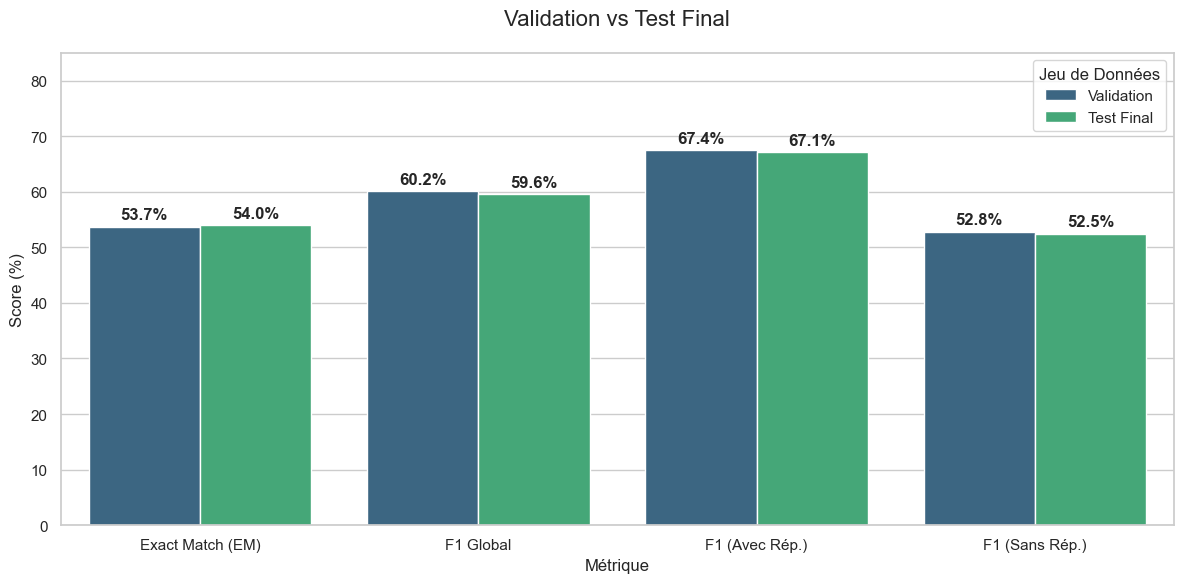

In [34]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# 1. CHARGEMENT DES FICHIERS JSON
try:
    with open(val_result, "r") as f:
        data_val = json.load(f)
    with open(test_result, "r") as f:
        data_test = json.load(f)
    print("✅ Fichiers chargés avec succès !")
except FileNotFoundError:
    print(f"❌ Erreur : Impossible de trouver '{val_result}' ou '{test_result}'.")
    # On crée des fausses données pour que le code ne plante pas si vous testez sans fichiers
    data_val = {"exact": 0, "f1": 0, "HasAns_f1": 0, "NoAns_f1": 0, "dataset_name": "Validation"}
    data_test = {"exact": 0, "f1": 0, "HasAns_f1": 0, "NoAns_f1": 0, "dataset_name": "Test"}

# 2. TRANSFORMATION EN TABLEAU (DATAFRAME)
rows = []

for data in [data_val, data_test]:
    nom_set = data.get("dataset_name", "Inconnu")
    
    rows.append({"Métrique": "Exact Match (EM)", "Score (%)": data["exact"], "Jeu de Données": nom_set})
    rows.append({"Métrique": "F1 Global",        "Score (%)": data["f1"],    "Jeu de Données": nom_set})
    rows.append({"Métrique": "F1 (Avec Rép.)",   "Score (%)": data["HasAns_f1"], "Jeu de Données": nom_set})
    rows.append({"Métrique": "F1 (Sans Rép.)",   "Score (%)": data["NoAns_f1"],  "Jeu de Données": nom_set})

df = pd.DataFrame(rows)

# 3. GÉNÉRATION DU GRAPHIQUE
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))

ax = sns.barplot(
    data=df, 
    x='Métrique', 
    y='Score (%)', 
    hue='Jeu de Données', 
    palette="viridis"
)

# --- CORRECTION ICI ---
for container in ax.containers:
    # On utilise 'weight' au lieu de 'fontWeight'
    ax.bar_label(container, fmt='%.1f%%', padding=3, weight='bold') 

# Titres
plt.title("Validation vs Test Final", fontsize=16, pad=20)
plt.ylabel("Score (%)")
plt.ylim(0, 85)
plt.legend(title="Jeu de Données", loc='upper right')

plt.tight_layout()
plt.show()